In [6]:
!pip install matplotlib --user

  Using cached matplotlib-3.7.1-cp311-cp311-win_amd64.whl (7.6 MB)
  Using cached contourpy-1.0.7-cp311-cp311-win_amd64.whl (162 kB)
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)



[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import random
from cv2 import resize
from glob import glob

In [4]:
img_height = 224
img_width = 224


train_ds = tf.keras.utils.image_dataset_from_directory(
  'Dataset',
  validation_split=0.2,
  subset='training',
  image_size=(img_height, img_width),
  batch_size=32,
  seed=42,
  shuffle=True)

val_ds = tf.keras.utils.image_dataset_from_directory(
  'Dataset',
  validation_split=0.2,
  subset='validation',
  image_size=(img_height, img_width),
  batch_size=32,
  seed=42,
  shuffle=True)


Found 6279 files belonging to 7 classes.
Using 5024 files for training.
Found 6279 files belonging to 7 classes.
Using 1255 files for validation.


Let's load VGG-16 pretrained on imagenet as the base model.

In [4]:
base_model = tf.keras.applications.VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(img_height, img_width, 3)
)
base_model.trainable = False # Freeze VGG-16 for now

In [6]:
inputs = tf.keras.Input(shape=(img_height, img_width, 3))
x = tf.keras.applications.vgg16.preprocess_input(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(90)(x)
model = tf.keras.Model(inputs, outputs)

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_1   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_1   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                           

In [7]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [8]:
num_epochs = 10
model.fit(train_ds, validation_data=val_ds, epochs=num_epochs,
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss",
            min_delta=1e-2,
            patience=2,
            verbose=1,
            restore_best_weights=True
        )
    ]
)

Epoch 1/10
157/157 [==============================] - 324s 2s/step - loss: 2.9968 - accuracy: 0.4047 - val_loss: 1.1774 - val_accuracy: 0.6215
Epoch 2/10
157/157 [==============================] - 323s 2s/step - loss: 1.2641 - accuracy: 0.5828 - val_loss: 0.9172 - val_accuracy: 0.6669
Epoch 3/10
157/157 [==============================] - 319s 2s/step - loss: 1.0184 - accuracy: 0.6365 - val_loss: 0.8214 - val_accuracy: 0.6916
Epoch 4/10
157/157 [==============================] - 316s 2s/step - loss: 0.9031 - accuracy: 0.6590 - val_loss: 0.7936 - val_accuracy: 0.6972
Epoch 5/10
157/157 [==============================] - 315s 2s/step - loss: 0.8547 - accuracy: 0.6833 - val_loss: 0.7941 - val_accuracy: 0.6964
Epoch 6/10
157/157 [==============================] - 319s 2s/step - loss: 0.8137 - accuracy: 0.6881 - val_loss: 0.7391 - val_accuracy: 0.7179
Epoch 7/10
157/157 [==============================] - 321s 2s/step - loss: 0.7867 - accuracy: 0.6941 - val_loss: 0.7927 - val_accuracy: 0.7124

In [10]:
# fine tuning
base_model.trainable = True
for layer in base_model.layers[:14]:
    layer.trainable = False
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_1   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_1   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                           

In [11]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [12]:
num_epochs = 5
history = model.fit(train_ds, validation_data=val_ds, epochs=num_epochs,
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss",
            min_delta=1e-2,
            patience=2,
            verbose=1,
        )
    ]
)

Epoch 1/5
157/157 [==============================] - 377s 2s/step - loss: 0.8008 - accuracy: 0.6871 - val_loss: 0.6507 - val_accuracy: 0.7625
Epoch 2/5
157/157 [==============================] - 379s 2s/step - loss: 0.5466 - accuracy: 0.7858 - val_loss: 0.5795 - val_accuracy: 0.7777
Epoch 3/5
157/157 [==============================] - 378s 2s/step - loss: 0.3798 - accuracy: 0.8545 - val_loss: 0.5397 - val_accuracy: 0.8215
Epoch 4/5
157/157 [==============================] - 380s 2s/step - loss: 0.2704 - accuracy: 0.8965 - val_loss: 0.6630 - val_accuracy: 0.7944
Epoch 5/5
157/157 [==============================] - 372s 2s/step - loss: 0.2156 - accuracy: 0.9218 - val_loss: 0.6847 - val_accuracy: 0.8096
Epoch 5: early stopping


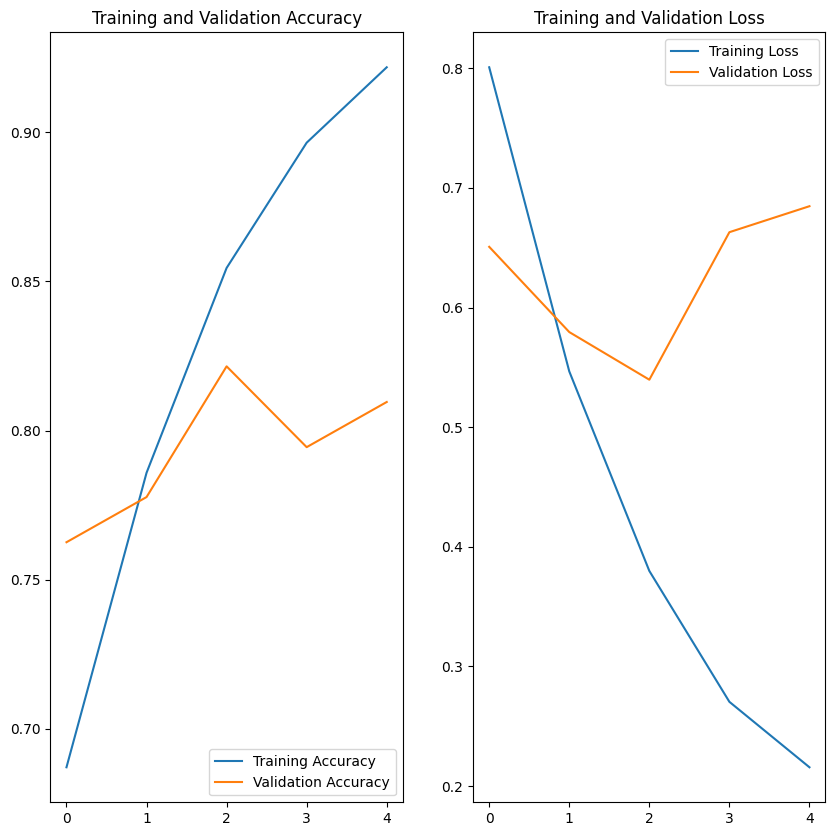

In [15]:
# Model Evaluation by comparing the training and validation accuracy as well as the loss.
acc = history.history['accuracy']
history.history
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
#
epochs_range = range(5)
#
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
#
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [16]:
model.save("poisonous-plants.h5")

After training, choose a random picture and see its prediction.

In [5]:
detection_path = "Dataset/Not/1.jpg"

img = tf.keras.utils.load_img(
    detection_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(
    "{} most likely belongs to {} with a {:.2f} percent confidence."
    .format(detection_path, train_ds.class_names[np.argmax(score)], 100 * np.max(score))
)

plt.figure(figsize=(2, 2))
plt.imshow((img_array[0].numpy()).astype('uint8'))
plt.title("{}:{:.2f}".format(train_ds.class_names[np.argmax(score)], 100 * np.max(score)))
plt.axis('off')

NameError: name 'model' is not defined